Сверточная нейронная сеть. Распознавание рукописных букв русского алфавита.

In [ ]:
!pip install sklearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torchvision
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('\content\gdrive')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Подготовка данных

In [ ]:
labels_map = {0: 'А', 1: 'Б', 2: 'В', 3: 'Г', 4: 'Д', 5: 'Е', 6: 'Ё', 7: 'Ж',
                 8: 'З', 9: 'И', 10: 'Й', 11: 'К', 12: 'Л', 13: 'М', 14: 'Н',
                 15: 'О', 16: 'П', 17: 'Р', 18: 'С', 19: 'Т', 20: 'У', 21: 'Ф',
                 22: 'Х', 23: 'Ц', 24: 'Ч', 25: 'Ш', 26: 'Щ', 27: 'Ъ', 28: 'Ы',
                 29: 'Ь', 30: 'Э', 31: 'Ю', 32: 'Я'}

In [ ]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                # transforms.RandomRotation(degrees=(15, 15)),
                                transforms.ToTensor()])

data = datasets.ImageFolder('/content/contentgdrive/MyDrive/train/Cyrillic_smooth',
                            transform=transform)

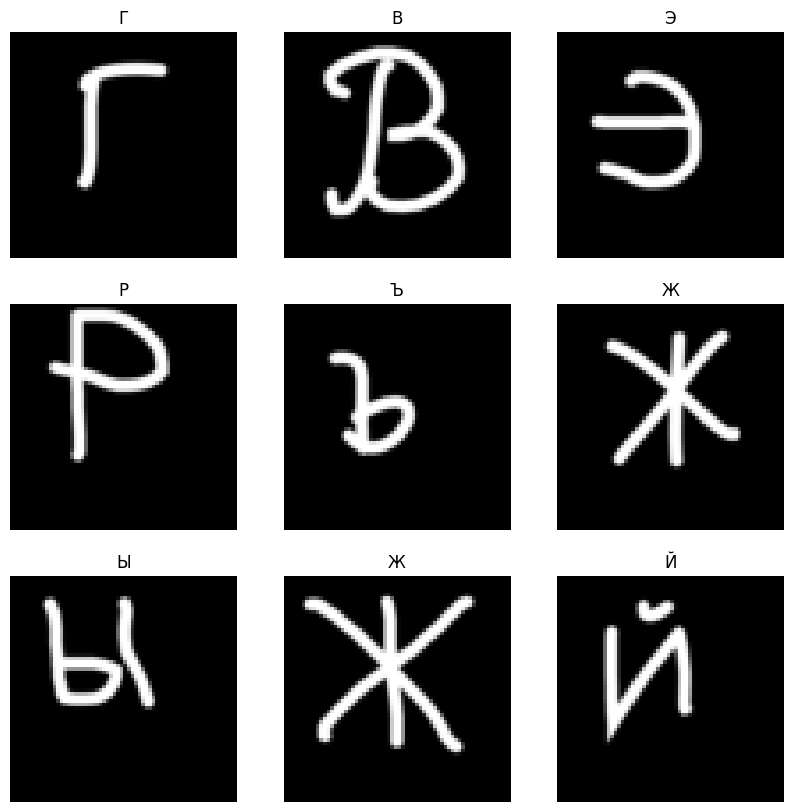

In [ ]:
#@title Посмотрим на данные:

figure = plt.figure(figsize=(10, 10))

for i in range(1, 10):
    sample = np.random.randint(0, len(data))
    img, label = data[sample]
    figure.add_subplot(3, 3, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))

plt.show()

In [ ]:
# Разделим датасет на обучающую, валидационную и тестовую выборки:

train_val_idx, test_idx = train_test_split(list(range(len(data))),test_size=0.3,    # 0.3
                                      random_state=42)
train_idx, val_idx = train_test_split(train_val_idx,test_size=0.3,   # 0.3
                                      random_state=42)
dataset_train = torch.utils.data.Subset(data, train_idx)
dataset_val = torch.utils.data.Subset(data, val_idx)
dataset_test = torch.utils.data.Subset(data, test_idx)

## Строим модель и обучаем многоклассовый классификатор.

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.0003      # 0.004  0.001
EPOCHS = 80                # 

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class LetterRecognizer(nn.Module):
    def __init__(self, input_size: int = [3, 128, 128], num_of_classes: int = 33):
        super(LetterRecognizer, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            
            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            # nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            
            # nn.BatchNorm2d(64),
            nn.Flatten(),
            nn.Dropout(p=0.1),    #  3
            nn.Linear(in_features=193600, out_features=128),     #256
            nn.ReLU(),
            nn.Dropout(p=0.1),    #  3
            nn.Linear(in_features=128, out_features=num_of_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# model = torch.load('/content/contentgdrive/MyDrive/train/64_0.0003_80_15.pth')

In [ ]:
# Отправим модель на device
model = LetterRecognizer()
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)    # SGD(momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Заведем списки accuracy_vs_epoch и loss_vs_epoch, чтобы построить графики
# изменения accuracy и loss с эпохами:
train_accuracy_vs_epoch = []
train_loss_vs_epoch = []
test_accuracy_vs_epoch = []
test_loss_vs_epoch = []

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_n, summary_writer):
    
    len_of_dataset = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)

    train_loss = 0
    train_accuracy = 0
    
    model.train()

    with tqdm(dataloader, unit='batch') as tqdm_epoch:
        for images, labels in tqdm_epoch:

            tqdm_epoch.set_description(f'Epoch {epoch_n}')
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = loss_fn(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            correct = (pred.argmax(1) == labels).sum().item()
            accuracy = correct / batch_size

            train_loss += loss.item()
            train_accuracy += correct
            
            tqdm_epoch.set_postfix(loss=loss.item(), accuracy=accuracy)
            
    # Средние потери и точность
    train_loss /= num_batches
    train_accuracy /= len_of_dataset

    train_loss_vs_epoch.append(train_loss)
    train_accuracy_vs_epoch.append(train_accuracy)

    summary_writer.add_scalar('train/loss', train_loss, epoch_n)
    summary_writer.add_scalar('train/accuracy', train_accuracy, epoch_n)


In [ ]:
def test_loop(dataloader, model, loss_fn, epoch_n,  summary_writer):
    
    len_of_dataset = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
        
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= len_of_dataset

    test_loss_vs_epoch.append(test_loss)
    test_accuracy_vs_epoch.append(correct)

    summary_writer.add_scalar('test/loss', test_loss, epoch_n)
    summary_writer.add_scalar('test/accuracy', correct, epoch_n)

    print(f'Test Metrics: \n Accuracy: {(correct):>0.3f}, Avg loss: {test_loss:>8f} \n')

In [ ]:
writer = SummaryWriter('runs/resnet_ft')

for epoch_n in range(EPOCHS):
    train_loop(train_dataloader, model, loss_fn, optimizer, epoch_n, writer)
    test_loop(val_dataloader, model, loss_fn, epoch_n, writer)

writer.close()

In [ ]:
torch.save(model, '/content/contentgdrive/MyDrive/train/64_0.0003_80_15.pth')

In [ ]:
model_loaded = torch.load('/content/contentgdrive/MyDrive/train/model.pth')

In [ ]:
summary(model_loaded, (3, 128, 128))

## Confusion matrix

In [ ]:
# transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

# test_data = datasets.ImageFolder('/content/contentgdrive/MyDrive/train/Letters', transform=transform)

In [ ]:
df_preds_val = pd.DataFrame(columns=['y_pred', 'y_true'])
writer = SummaryWriter('runs/resnet_ft')

model.eval()
for image, label in tqdm(dataset_test, total=len(dataset_test)):
    with torch.inference_mode():
        image = image.to(device)
        image = image.unsqueeze(0)
        logits = model(image)
        
        df_pred = pd.DataFrame([[torch.argmax(logits).item(), label]],
                               columns=['y_pred', 'y_true'])
        df_preds_val = pd.concat([df_preds_val, df_pred], ignore_index=True)

writer.close()

  0%|          | 0/4352 [00:00<?, ?it/s]

In [ ]:
idx_to_class = {v: k for k, v in data.class_to_idx.items()}

df_preds_val['y_pred'] = df_preds_val['y_pred'].apply(lambda x:idx_to_class[x])
df_preds_val['y_true'] = df_preds_val['y_true'].apply(lambda x:idx_to_class[x])

df_preds_val['y_pred'] = df_preds_val['y_pred'].apply(lambda x:x.replace('_', ' ').title())
df_preds_val['y_true'] = df_preds_val['y_true'].apply(lambda x:x.replace('_', ' ').title())

[Text(0, 0.5, 'Щ'),
 Text(0, 1.5, 'Б'),
 Text(0, 2.5, 'Ш'),
 Text(0, 3.5, 'К'),
 Text(0, 4.5, 'Ё'),
 Text(0, 5.5, 'Х'),
 Text(0, 6.5, 'Т'),
 Text(0, 7.5, 'Ч'),
 Text(0, 8.5, 'В'),
 Text(0, 9.5, 'Э'),
 Text(0, 10.5, 'Ы'),
 Text(0, 11.5, 'А'),
 Text(0, 12.5, 'Л'),
 Text(0, 13.5, 'Н'),
 Text(0, 14.5, 'Я'),
 Text(0, 15.5, 'З'),
 Text(0, 16.5, 'Р'),
 Text(0, 17.5, 'Ф'),
 Text(0, 18.5, 'Ц'),
 Text(0, 19.5, 'Ъ'),
 Text(0, 20.5, 'Е'),
 Text(0, 21.5, 'Ь'),
 Text(0, 22.5, 'П'),
 Text(0, 23.5, 'С'),
 Text(0, 24.5, 'Д'),
 Text(0, 25.5, 'Ю'),
 Text(0, 26.5, 'У'),
 Text(0, 27.5, 'Ж'),
 Text(0, 28.5, 'Й'),
 Text(0, 29.5, 'Г'),
 Text(0, 30.5, 'М'),
 Text(0, 31.5, 'И'),
 Text(0, 32.5, 'О')]

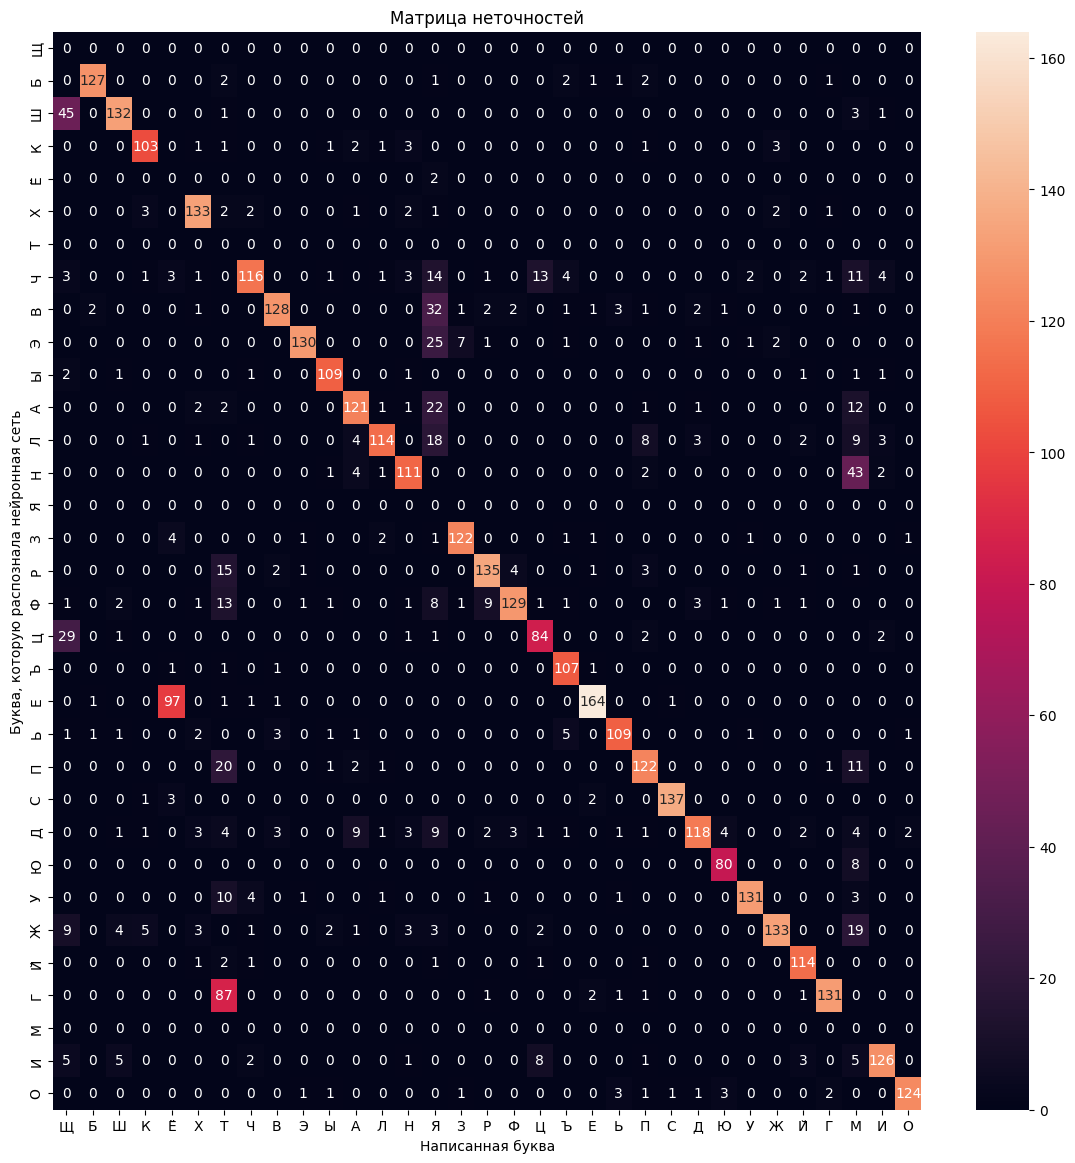

In [ ]:
labels = df_preds_val['y_true'].unique()
cm = confusion_matrix(df_preds_val['y_pred'], df_preds_val['y_true'], labels=labels)

fig, ax = plt.subplots(1, 1, figsize=(14, 14))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Написанная буква')
ax.set_ylabel('Буква, которую распознала нейронная сеть')
ax.set_title('Матрица неточностей')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('/content/contentgdrive/MyDrive/train/CNN_64_80.png')

## Проверка модели на валидационной выборке

In [ ]:
BATCH_SIZE = 64

In [ ]:
writer = SummaryWriter('runs/resnet_ft')

test_loop(test_dataloader, model, loss_fn, EPOCHS, writer)

writer.close()

Test Metrics: 
 Accuracy: 0.779, Avg loss: 2.769086 



In [ ]:
x = [i for i in range (num_of_epochs+1)]

plt.plot(x, train_loss_vs_epoch, 'o-r')
plt.xlabel('Номер эпохи.')
plt.ylabel('Значение потерь')
plt.title('Значение функции потерь в эпохах.')
plt.grid(True)
plt.show()

plt.plot(x, train_accuracy_vs_epoch, 'o-g')
plt.xlabel('Номер эпохи.')
plt.ylabel('Accuracy')
plt.title('Значение accuracy в эпохах.')
plt.grid(True)
plt.show()